# TITLE: Brush Motor Torque Analysis
# AUTHOR: Samuel Law

# Utilities

In [19]:
def show(eq_lhs: str, eq_rhs: str)->display:
    eq = f"${eq_lhs} = {eq_rhs}$"
    return display(Latex(eq))

def in2m(inches: float) -> float:
    return inches*25.4/1000

def lbf2N(lbf: float) -> float:
    return lbf*4.44822

# Kinematics and Dynamics

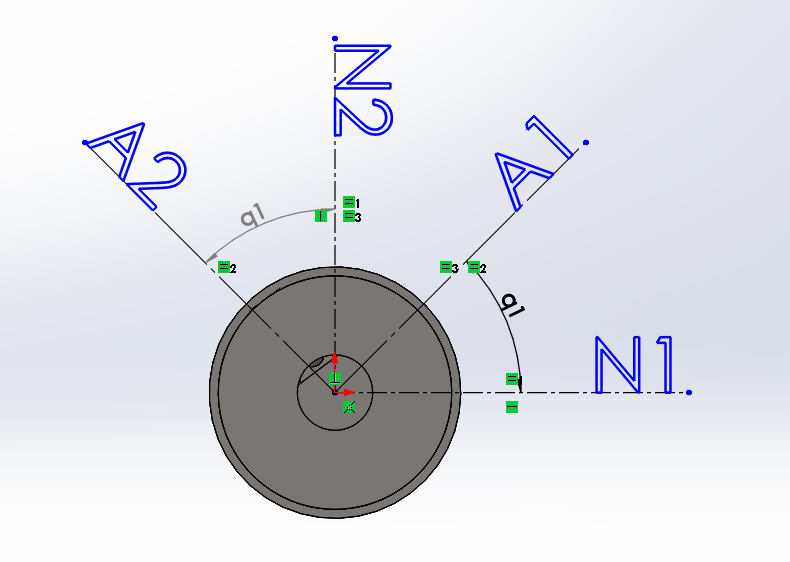

### Assumptions
* The motion of the gear belt applies a pure moment about brushes z-axis.
* The friction between the tube and the brush is a function of the coefficient of friction<br>
  between the two materials and the bristle deflection. 
* The target RPM's are to be determined.

In [20]:
import sympy as sm
import sympy.physics.mechanics as me
from IPython.display import display, Latex

In [21]:
# create symbolic constants
Izz, Tau_dt, Tau_t, Tau_m, L, ma, g = sm.symbols("Izz, Tau_dt, Tau_t, Tau_m, L, ma, g")

# create dict to hold literal vals
vals = {
    g: 9.81,  # m/s^2
    Izz: 2e-5  # kg*m^2
}

In [22]:
# define q1 and it's dirivatives
q1 = me.dynamicsymbols('q1')
q1d = me.dynamicsymbols('q1', 1)
q1dd = me.dynamicsymbols('q1', 2)

In [23]:
# define inertial frame and point
N = me.ReferenceFrame("N")
pN = me.Point("pN")
pN.set_vel(N, 0)

# define body frame and com
A = N.orientnew("A", "axis", (q1, N.z))
pA = pN.locatenew("pA", L*A.z)
pA.set_vel(N, 0)
pA.set_acc(N, 0)

# define angular velocity and acceleration
A.set_ang_vel(N, q1d*A.z)
A.set_ang_acc(N, q1dd*A.z)

# define external forces and moments
fga = ma*g*-N.z  # gravity
tau1 = Tau_m*A.z    # motor torque
tau2 = Tau_t*-A.z    # counter torque from tube
tau3 = Tau_dt*-A.z   # counter torque from drivetrain

# define the equations of motion
Fi = sum([
    fga.dot(pA.vel(N)),
    tau1.dot(A.ang_vel_in(N)),
    tau2.dot(A.ang_vel_in(N)),
    tau3.dot(A.ang_vel_in(N))
])

Fis = sum([
    ma*pA.acc(N).dot(pA.vel(N)),
    Izz*A.ang_acc_in(N).dot(A.ang_vel_in(N)),
])

# solve the equations of motion using Kanes method
sol = sm.solve([Fi - Fis],[q1dd])
vals.update({q1dd: sol[q1dd]})
show(r"\ddot{q_1}", me.vlatex(sol[q1dd]))

<IPython.core.display.Latex object>

# Friction Torque Estimate Calculation

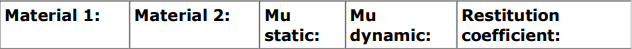<br>
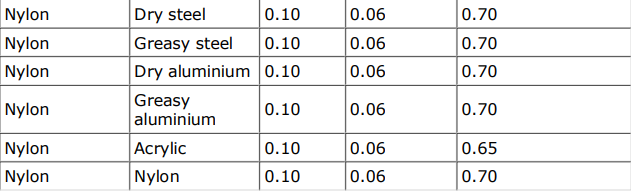

### Assumptions
* The deflection of the bristle is due completely to normal force against the tube.
* The dynamic friction remains relativly constant between nylon and other materials.
* The bristle length is approximitly equal to the brush radius.
* The brush will always be spinning prior to contact with the tube, thus Mu static is not required.
* The deflected brush shape will be a perfectly circular arc.

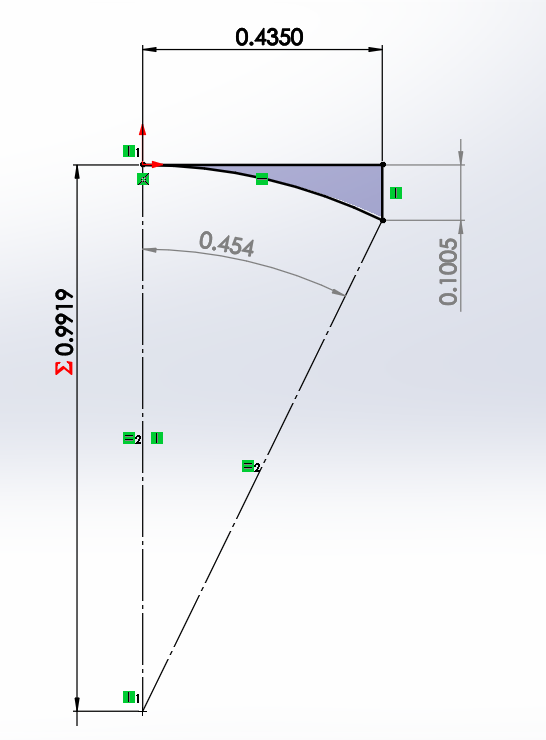

In [25]:
# define knowns
delta = 0.1005  # in, deflectin in the y dir
r = 0.9919      # in, radius of curvature
L = 0.4350      # in, tube radius
d = 0.022       # in, bristle diameter 

# define variables
P, y, x, R, C1, C2, E, I = sm.symbols("P, y, x, R, C1, C2, E, I")

# solve for C1
dydx = x/(-(y+R))
eq1 = (P*y*x) - ((E*I*dydx) + C1)
sol, *_ = sm.solve([eq1], [C1], dict=True)
C1 = sol[C1]

# solve for C2
eq2 = (P*y*(x**2)/2) - ((E*I*y) + (C1*x) + C2)
sol, *_ = sm.solve([eq2], [C2], dict=True)
C2 = sol[C2]

# use boundry conditions to get exact solutions for C1 and C2
boundry_conditions = {
    "L": {y: delta, R: r, x: L},
    "0": {y: 0, R: r, x: 0},
}

# show the symbolic answers
show("C1", sm.latex(C1)) 
show("C2", sm.latex(C2))

# substitute the values back into C1 and C2
C1 = C1.subs(boundry_conditions["0"])
C2 = C2.subs(boundry_conditions["0"])

# create equation 3
eq3 = (P*y*(x**2)/2) - ((E*I*y) + (C1*x) + C2)
show("0", sm.latex(eq3))

# solve equation 3 for P at x = L
eq3 = eq3.subs(boundry_conditions["L"])
sol, *_ = sm.solve([eq3], [P], dict=True)
P = sol[P]
show("P", sm.latex(P))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
# calculate the normal force
fn = P.subs({
    E: 0.4e6,                    # psi
    I: 0.25*sm.pi*((d/2)**4)     # in^4
})
fn = lbf2N(fn)                   # N
show("f_n", float(fn))

# calculate the frictional force
mu = 0.06                        # a.u.
ff = float(mu*fn)                # N
show("f_f", ff)

# calculate the frictional torque
Tf = ff*in2m(L)                  # N*m
show("T_f", Tf)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [33]:
# append to the values
vals.update({"fn": fn, "ff": ff, "Tf": Tf})

# Motor Torque Estimation

In [28]:
T_high = 1.12           # Motor torqe at "0 rpm" in Nm
T_low = 0.14            # Motor torque at the low end of the linear range in Nm
rad_high = 0            # rad/s at high torque
rad_low = 3000*sm.pi*2  # rad/s at low torqe

# solve for the slope of the curve
m = (T_low - T_high)/(rad_low - rad_high)

# solve for torque equation over linear range
x, y = sm.symbols("x, y")
eq = (y - T_high) - (m*(x - rad_low))
line_eq, *_ = sm.solve(eq, y)
print("y(x) =", line_eq)

# create a lambda function for the simulation
Tm = sm.lambdify(x, line_eq, modules="numpy")

y(x) = 2.1 - 5.19906147433525e-5*x


# Run the Simulation

In [29]:
import matplotlib.pyplot as plt
from scipy.integrate import RK45
from numpy import array, vstack

In [30]:
show("x_1", "q_1")
show("x_2", r"\dot{q_1}")
show(r"\dot{x_1}", "x_2")
show(r"\dot{x_2}", me.vlatex(sm.simplify(vals[q1dd])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

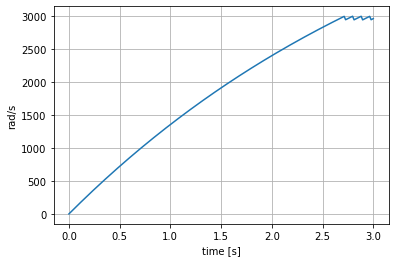

In [39]:
# model controls
IZZ = float(vals[Izz])  # single bush moment of inertia
n = 125*10              # number of bristles in contact with tube
rad_max = 3000          # maximum radians per second for the motor
brush_count = 10        # number brushes


def model(t, x):
    """base model for determining motor
    torque requirements"""
    # unpack the x vector
    x1, x2 = x
    
    # solve for the resistive torques
    Tau_dt = drivetrain_friction_torque(x2)
    Tau_t = brush_count*tube_friction_torque(x2)
    
    # solve for the motor torqe
    Tau_m = motor_torque(x2)
    
    # solve for brush_array_inertia
    Izz_array = brush_count*IZZ
    
    # assign values
    x1d = x2 
    x2d = (Tau_m - (Tau_dt + (Tau_t)))/(Izz_array)
    
    return (x1d, x2d)


def motor_torque(q1d):
    """returns: motor torque if rad/s are under the max"""
    val = Tm(q1d) if q1d < rad_max else 0
    return val


def drivetrain_friction_torque(q1d):
    """
    returns: torque due to drivetrain friction"""
    return 0
   
    
def tube_friction_torque(q1d):
    """ returns: torque due to brush interaction 
    with tube if rad/s are positive"""
    # only positive values have valid friction
    val = Tf*n if q1d > 0 else 0
    return val

# setup initila conditions
t0 = 0; t_final = 3.0;
x0 = [0, 0]
simulator = RK45(model, t0, x0, t_final, max_step=0.020)

# run the model
results = array(x0)
times = array(t0)
while True:
    try:
        simulator.step()
        times = vstack((times, simulator.t))
        results = vstack((results, simulator.y))
    except Exception:
        break

# q = results[:,0], qd = results[:,1]
plt.plot(times, results[:, 1]);
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("rad/s");

# References

[friction between material]  http://atc.sjf.stuba.sk/files/mechanika_vms_ADAMS/Contact_Table.pdf <br>
[normal force]  http://www.continuummechanics.org/columnbuckling.html <br>
[lb-in -> Nm]  https://www.convertunits.com/from/oz-in/to/N-m <br>
[lightweight motor torque curve] https://www.mcmaster.com/6331K13/ <br>